In [ ]:
import sysfrom pathlib import Pathfrom collections import Counterimport matplotlib.pyplot as pltimport numpy as npimport pandas as pdimport torchPROJECT_ROOT = Path().resolve().parents[1]if str(PROJECT_ROOT) not in sys.path:    sys.path.append(str(PROJECT_ROOT))from mnist_classifier.data import MNISTDataModulefrom nn_utils import get_hidden_states, load_modelsfrom nn_plotting import plot_perturved_accuracyfrom local_corex import LinearCorex, partition_datafrom local_corex._transformers import CorExWrapper, PCAWrapperfrom local_corex.utils.plotting import (    hidden_state_plot,    multi_rep_plot,)

Install CUDA and cudamat (for python) to enable GPU speedups.


In [2]:
base_path = "/home/TomKerby/Research/local_corex_private/scripts/mnist_classifier/model_output/do_classifier/rep_3"
# base_path = "/home/TomKerby/Research/local_corex_private/scripts/mnist_classifier/model_output/base_classifier/rep_1"

from scripts.mnist_classifier.model_output.do_classifier.rep_3.autoencoder_config import conf as ae_conf
# from scripts.mnist_classifier.model_output.base_classifier.rep_1.autoencoder_config import conf as ae_conf
from scripts.mnist_classifier.model_output.do_classifier.rep_3.config import conf as clf_conf
# from scripts.mnist_classifier.model_output.base_classifier.rep_1.config import conf as clf_conf

ae_conf = ae_conf['autoencoder']
# ae_ckpt = base_path + '/mnist_ae_epoch=084-val_loss=0.5200.ckpt'
ae_ckpt = base_path + '/mnist_ae_epoch=069-val_loss=0.5778.ckpt'
clf_conf = clf_conf['classifier']
# clf_ckpt = base_path + '/mnist_clf_epoch=042-val_loss=0.0024.ckpt'
clf_ckpt = base_path + '/mnist_clf_epoch=053-val_loss=0.0024.ckpt'

do_ae, do_clf = load_models(ae_ckpt, clf_ckpt, ae_conf, clf_conf)

data_module = MNISTDataModule(clf_conf, "/home/TomKerby/Research/local_corex_private/scripts/mnist_classifier")
data_module.setup('predict')

model_data = get_hidden_states(do_clf, data_module, device=do_clf.device, num_layers=len(clf_conf['hidden_layers']))

inputs=model_data[4]
labels=model_data[5]

do_state_df = pd.DataFrame({
    'input': list(inputs),
    'h1': list(model_data[1]),
    'h2': list(model_data[2]),
    'h3': list(model_data[3]),
    'output': list(model_data[0])
})

Calculating PHATE...
  Running PHATE on 10000 observations and 784 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.85 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.07 seconds.
  Calculated graph and diffusion operator in 4.36 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.55 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.34 seconds.
  Calculated landmark operator in 2.42 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 1.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.28 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 55.37 seconds.
Calculated PHATE in 63.64 seconds.
Group number: 0 Counter({1: 421, 7: 8, 4: 7, 9: 6, 6: 1})
Group number: 1 Counter({3: 870, 5: 381, 8: 105, 9: 9,

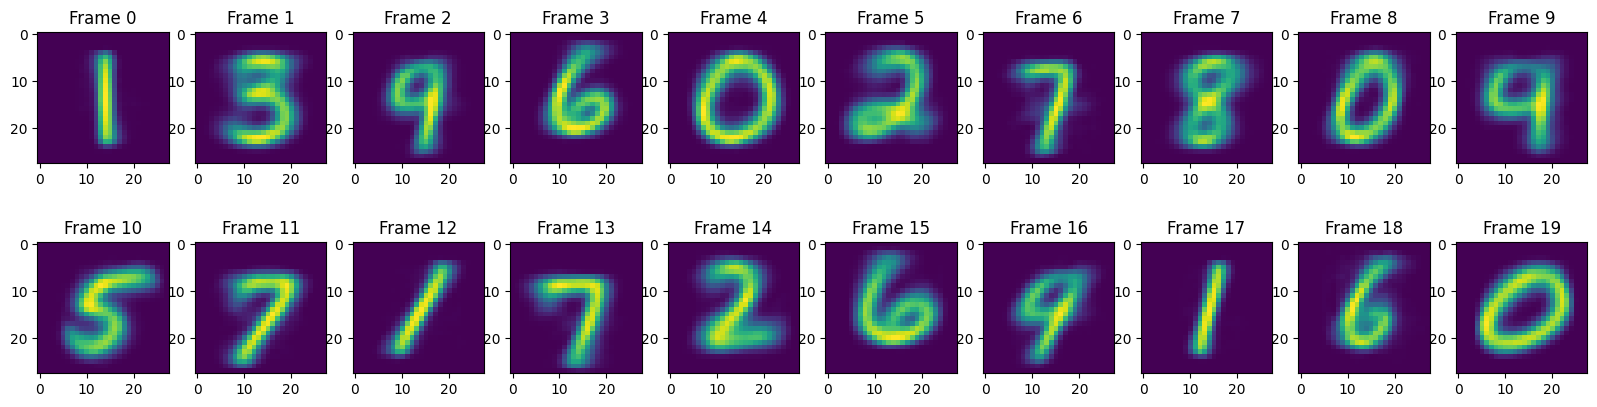

In [3]:
num_clusters=20
indexes = partition_data(inputs, n_partitions=num_clusters, phate_dim=10, n_jobs=-2, seed=42)
for i in range(0, num_clusters):
    print("Group number:", i, Counter(labels[indexes[i]]))

fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.mean(inputs[indexes[i]], axis = 0).reshape(28,28))
    ax.set_title('Frame ' + str(i))

[37.806934  37.19138   32.55226   28.076578  20.698845  14.349319
 10.0145645  9.977757   8.826794   7.9478683  7.50319    7.0829644
  6.5456276  6.4735556  5.961394   5.942745   5.4255624  4.814707
  3.832968   3.050899   3.0045414  2.8155773  2.705398   2.6517034
  2.6361718  2.400921   1.9887927  1.766068   1.5613676  1.4165674]


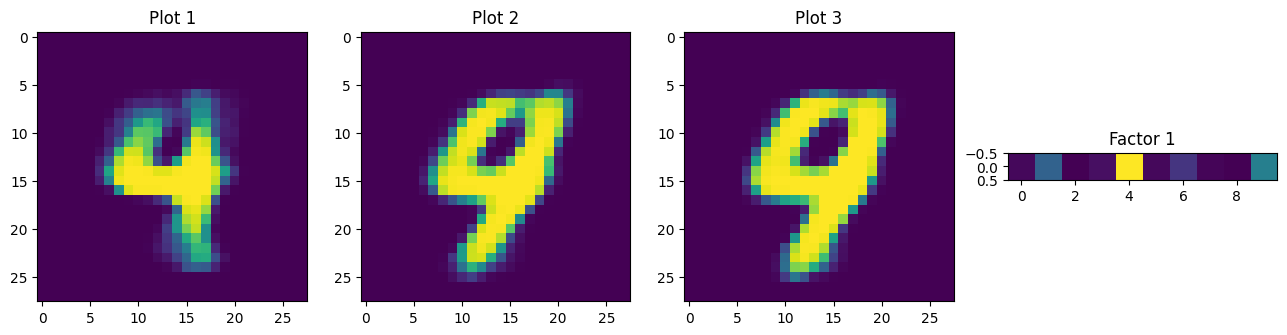

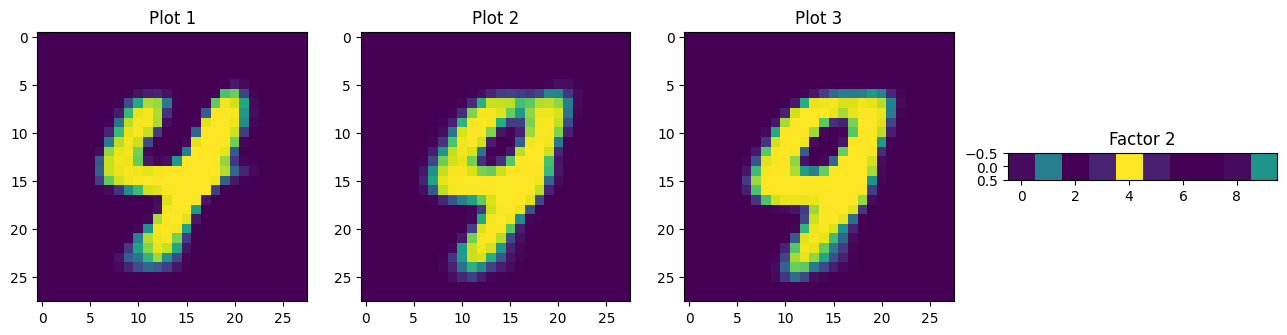

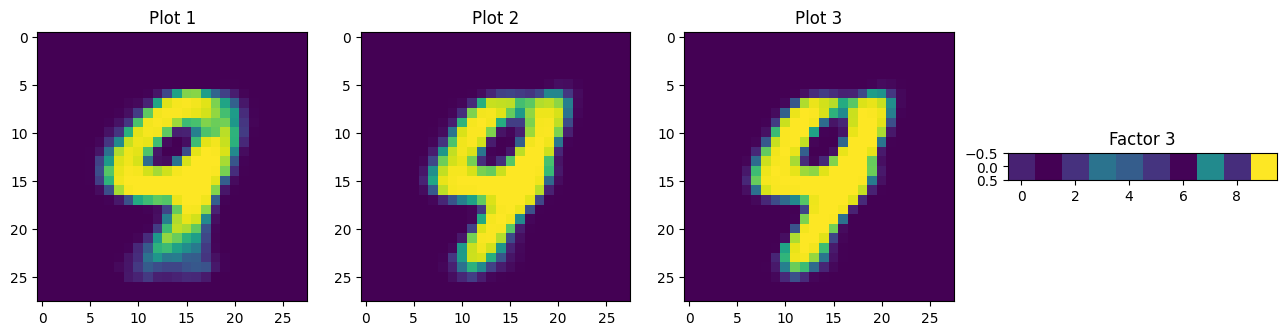

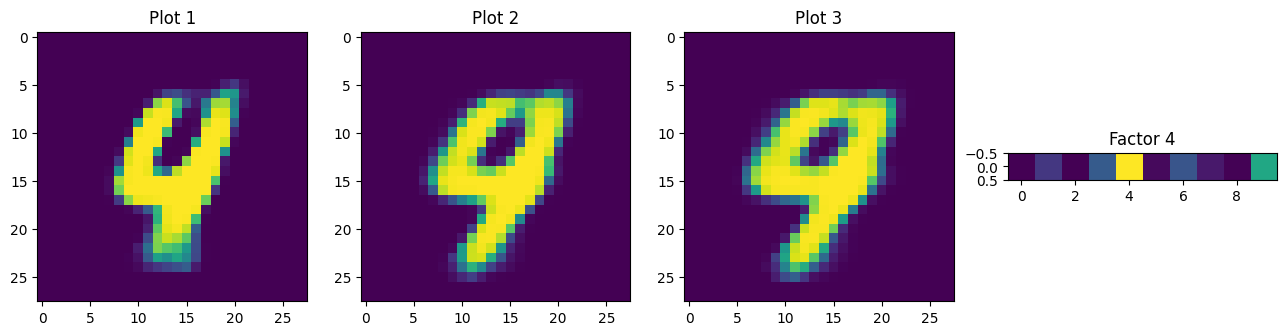

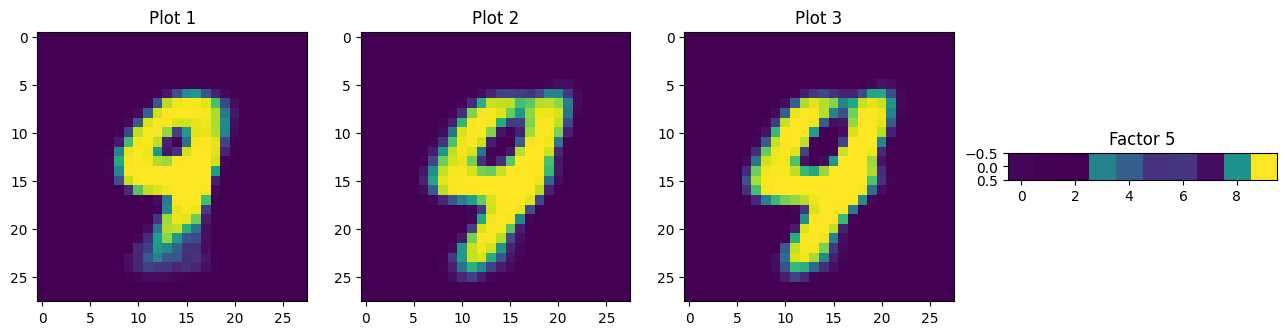

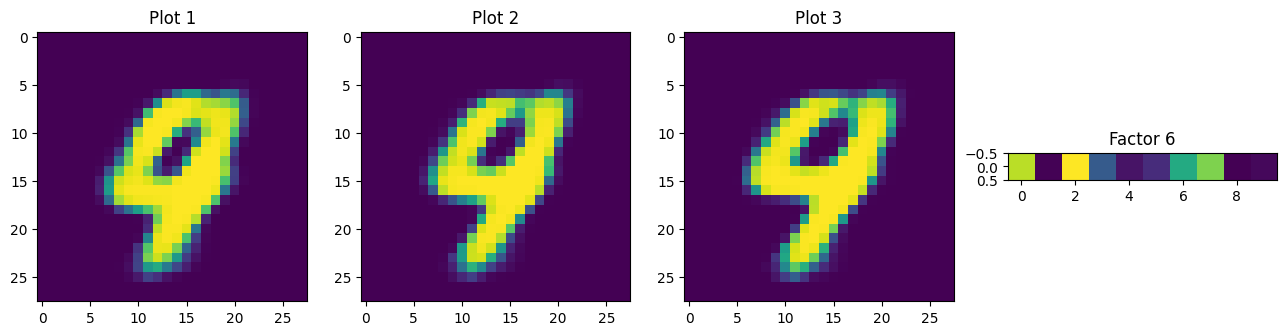

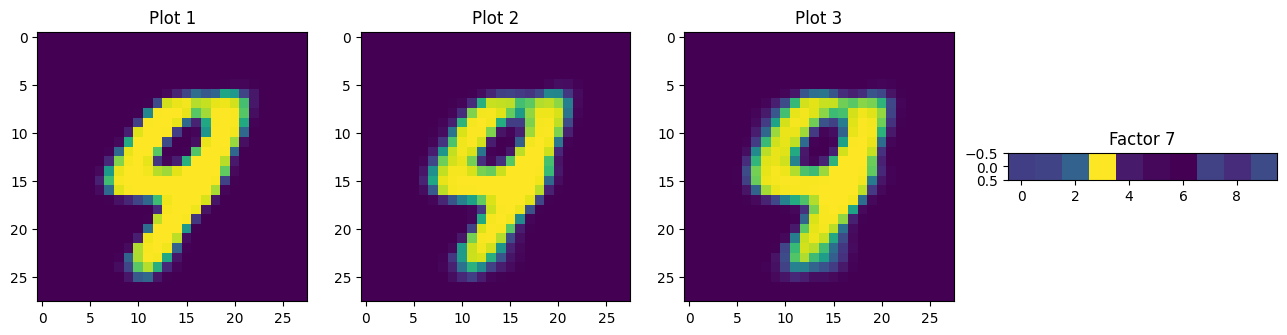

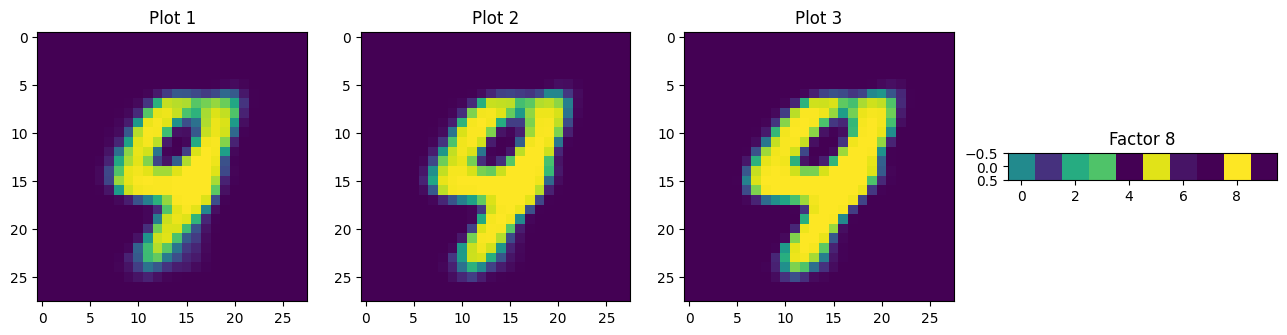

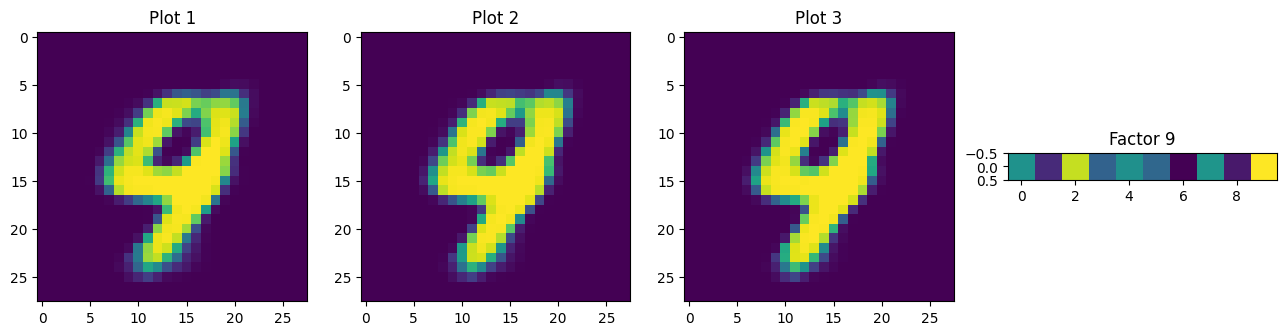

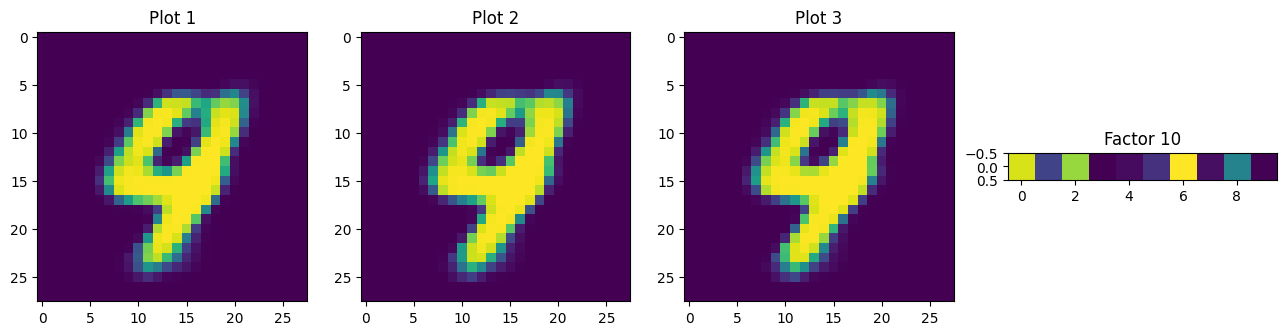

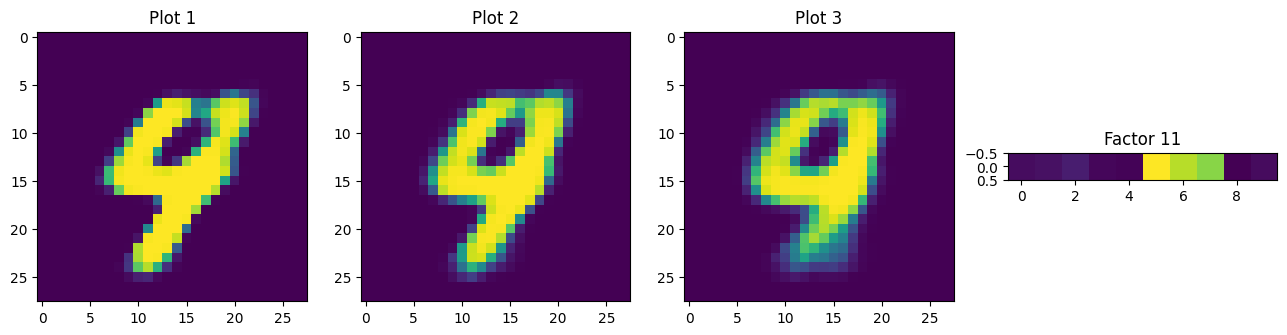

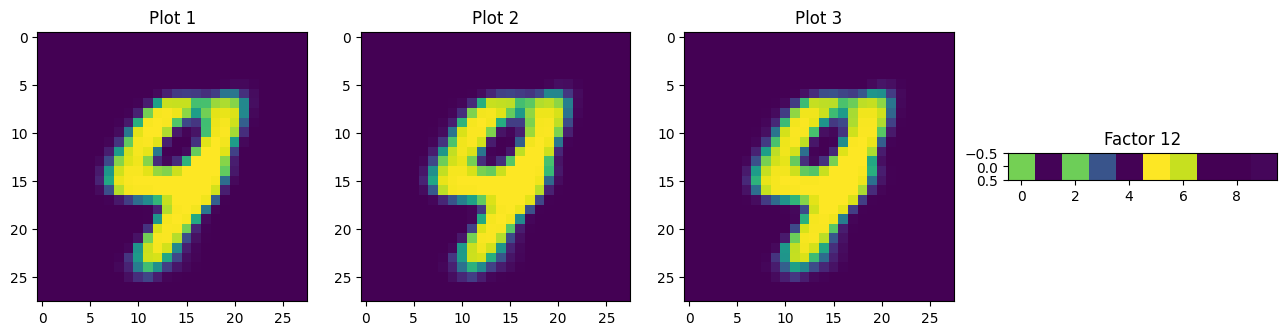

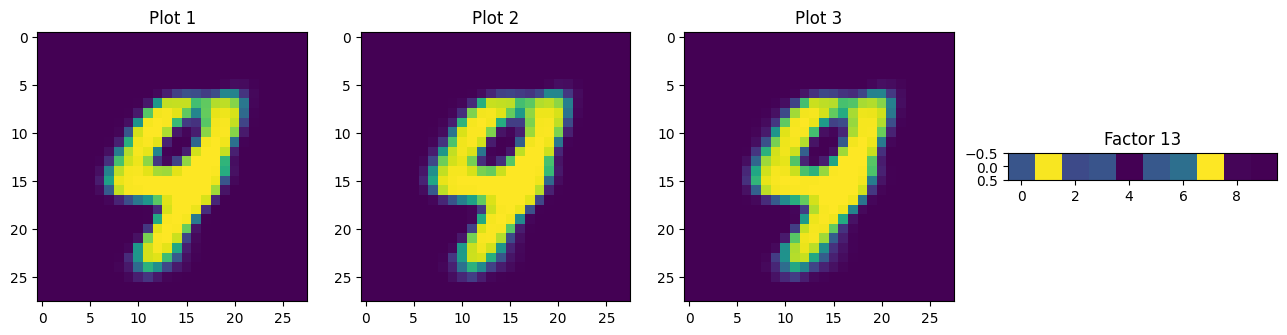

In [68]:
partition=16
x = np.concatenate([model_data[3][indexes[partition]], model_data[0][indexes[partition]]], axis=1)

corex_h3_16 = CorExWrapper(30)
corex_h3_16.fit(x)
print(corex_h3_16.corex.tcs)
hidden_state_plot(x, corex_h3_16, do_ae, factors=[0,1,2,3,4,5,6,7,8,9,10,11,12], latent_dim=ae_conf['decoder_layers'][0], encoder_layer=3, scaler=1.5)

[4.1258782e-01 3.2908234e-01 6.9703586e-02 4.8934944e-02 3.3082969e-02
 3.0683048e-02 2.1461667e-02 1.4627959e-02 1.0956295e-02 9.0149613e-03
 2.3131559e-03 1.7807824e-03 1.5910622e-03 1.3509177e-03 1.0787972e-03
 1.0023867e-03 9.3533134e-04 7.4562267e-04 6.7759107e-04 5.1993161e-04
 4.7667194e-04 4.1314200e-04 4.0269032e-04 3.4493176e-04 3.2821126e-04
 2.9879753e-04 2.5045380e-04 2.3947847e-04 2.3293639e-04 2.0874800e-04]


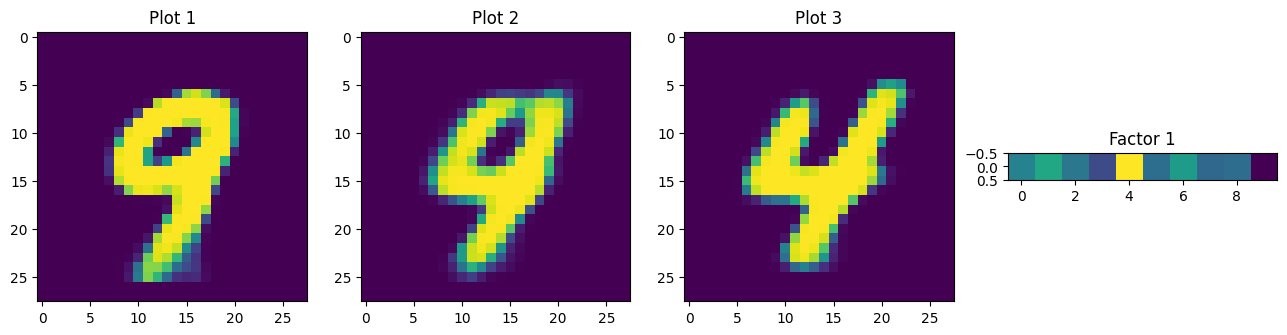

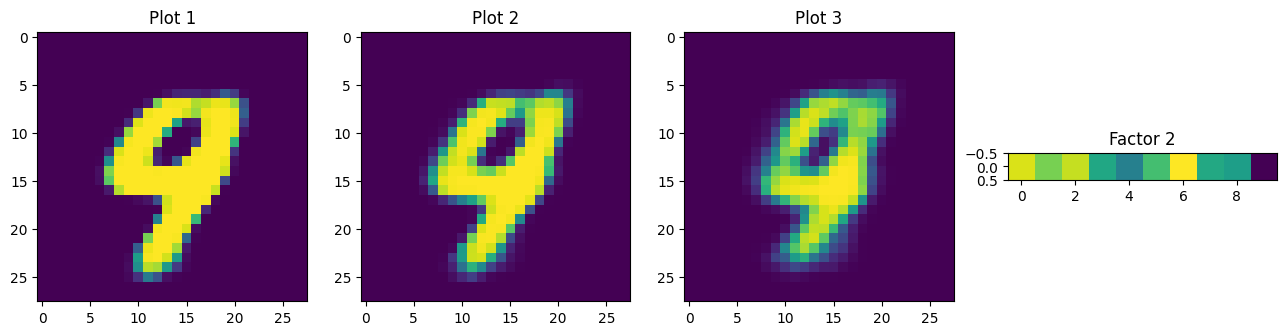

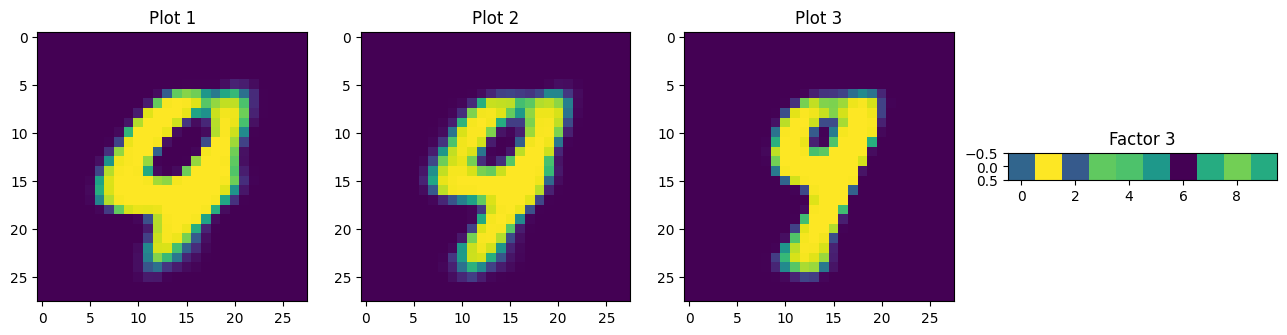

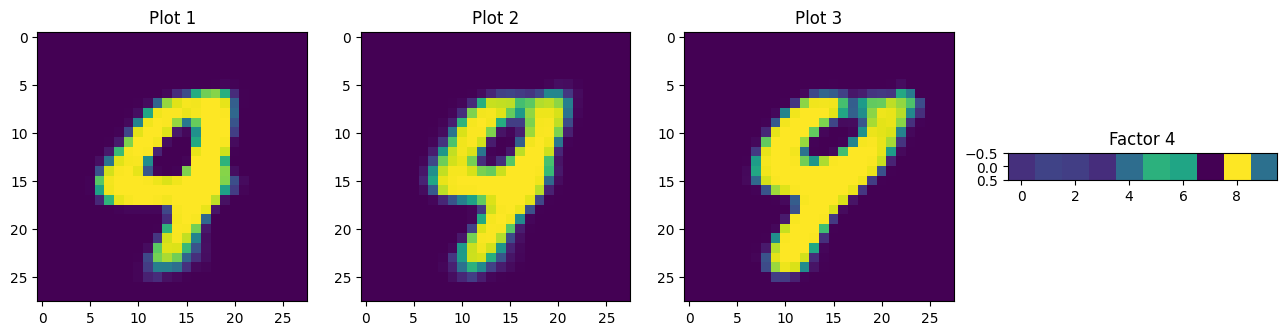

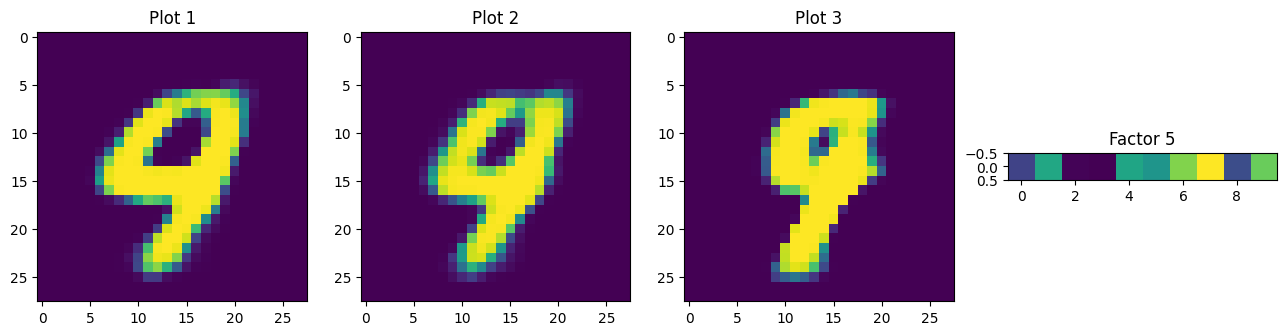

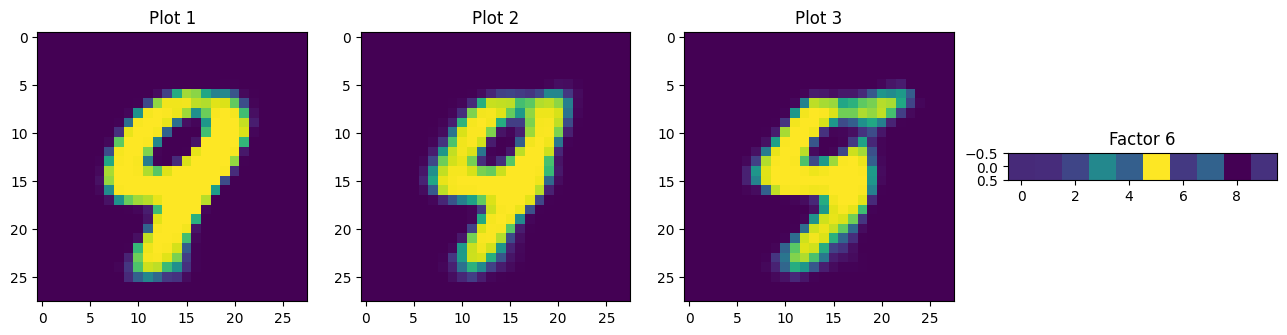

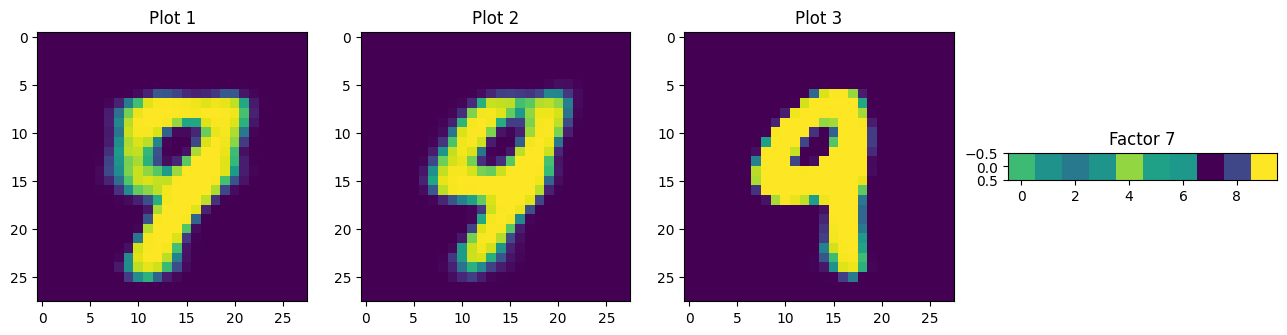

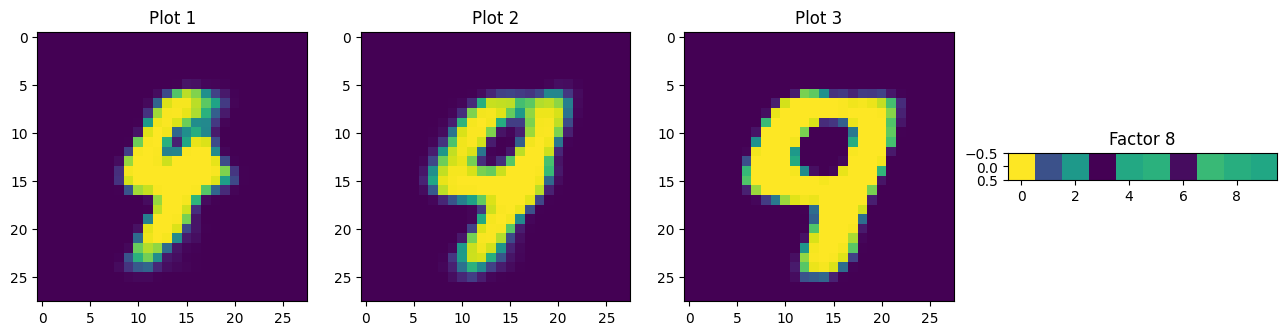

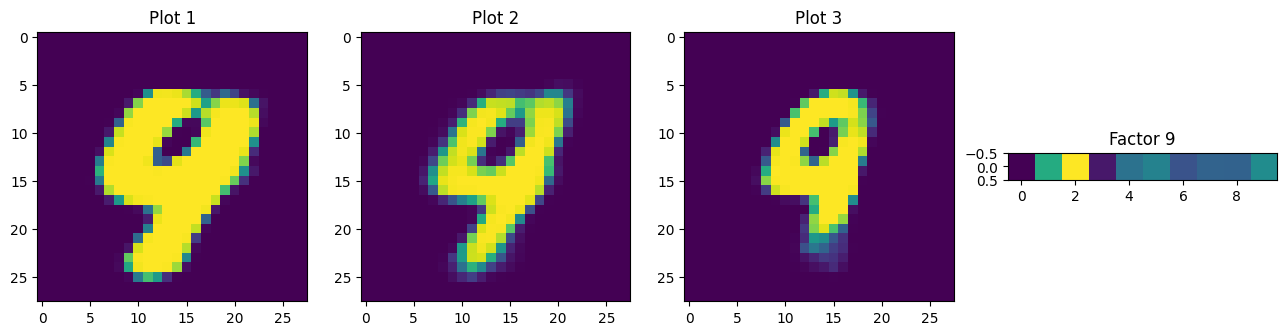

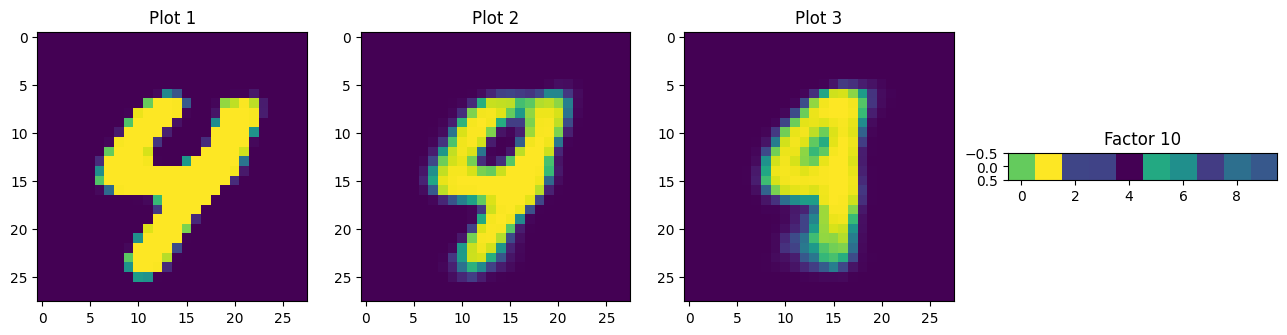

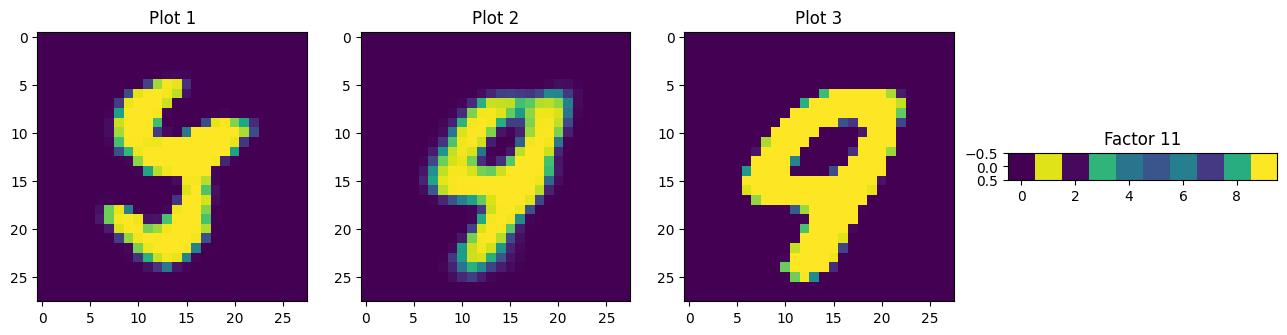

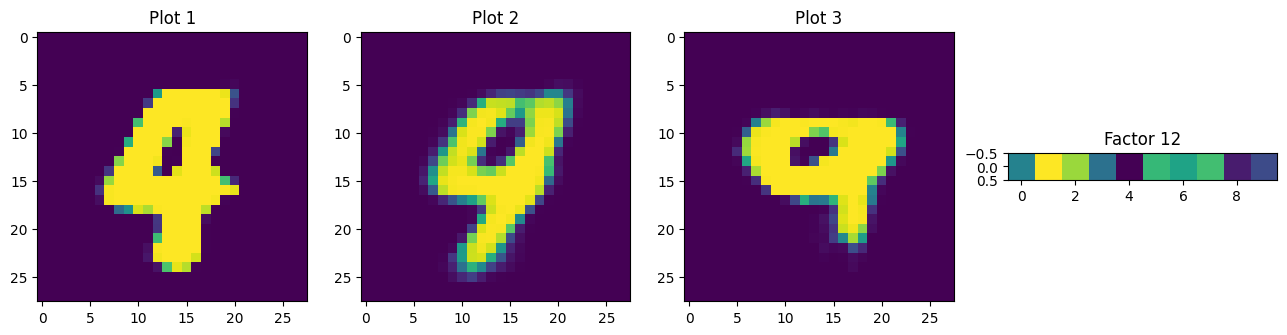

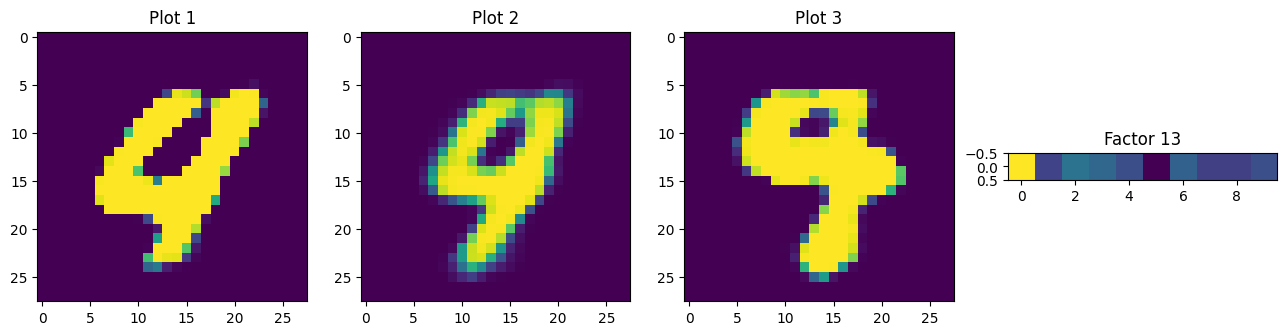

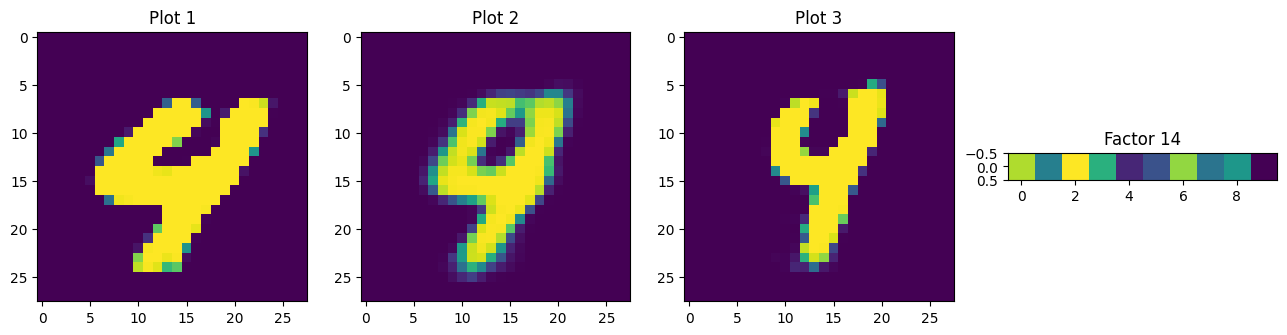

In [64]:
pca_h3_16 = PCAWrapper(30)
pca_h3_16.fit(x)
print(pca_h3_16.pca.explained_variance_ratio_)
hidden_state_plot(x, pca_h3_16, do_ae, factors=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], latent_dim=ae_conf['decoder_layers'][0], encoder_layer=3, scaler=15)

In [ ]:
h3_to_out_16 = LinearCorex(n_hidden=30, seed=42, gaussianize='outliers')
x = np.concatenate([model_data[3][indexes[partition]], model_data[0][indexes[partition]]], axis=1)
Y1_0 = h3_to_out_16.fit_transform(x)

print(h3_to_out_16.tcs)

multi_rep_plot(h3_to_out_16, 9, dims=[(10,20),(10,1)], num_per_row=3)
hidden_state_plot(x, h3_to_out_16, do_ae, num_factors=3, scaler=1, latent_dim=200, encoder_layer=3, output_dim=10, input_dim=(28,28))

In [ ]:
h2_to_out_16 = LinearCorex(n_hidden=30, seed=42, gaussianize='outliers')
x = np.concatenate([model_data[2][indexes[partition]], model_data[0][indexes[partition]]], axis=1)
Y1_0 = h2_to_out_16.fit_transform(x)

print(h2_to_out_16.tcs)

multi_rep_plot(h2_to_out_16, 9, dims=[(10,20),(10,1)], num_per_row=3)
hidden_state_plot(model_data[2][indexes[partition]], h2_to_out_16, do_ae, num_factors=3, scaler=1.2, latent_dim=200, encoder_layer=2, output_dim=10, input_dim=(28,28))

In [ ]:
h1_to_out_16 = LinearCorex(n_hidden=30, seed=42, gaussianize='outliers')
x = np.concatenate([model_data[1][indexes[partition]], model_data[0][indexes[partition]]], axis=1)
Y1_0 = h1_to_out_16.fit_transform(x)

print(h1_to_out_16.tcs)

multi_rep_plot(h1_to_out_16, 9, dims=[(10,20),(10,1)], num_per_row=3)
hidden_state_plot(model_data[1][indexes[partition]], h1_to_out_16, do_ae, num_factors=3, scaler=1, latent_dim=200, encoder_layer=1, output_dim=10, input_dim=(28,28))

In [6]:
do_clf.to('cpu')
pred_digit = do_clf(torch.tensor(inputs)).max(1).indices.detach().numpy()
base_accuracies = []
for i in range(num_clusters):
    base_accuracies.append(100*np.mean(pred_digit[indexes[i]] == labels[indexes[i]]))
    print(i, np.round(np.mean(pred_digit[indexes[i]] == labels[indexes[i]]) * 100, 2))

0 98.42
1 98.61
2 98.17
3 99.5
4 98.75
5 99.32
6 97.26
7 99.2
8 98.32
9 99.11
10 99.0
11 99.2
12 97.94
13 98.68
14 98.54
15 99.44
16 97.5
17 99.24
18 96.93
19 99.06


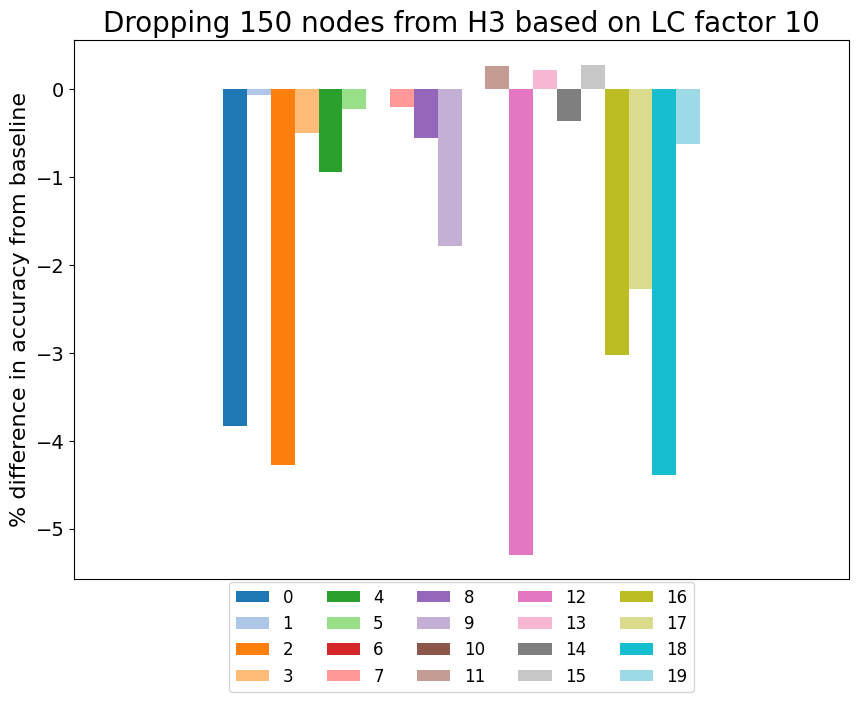

In [61]:
plot_perturved_accuracy(do_clf, pca_h3_16, inputs, labels, indexes, 
                             factor_num=9, hidden_layer_idx=2, num_clusters=20, 
                             num_drop=150, hidden_dim=300)

In [ ]:
output = plt.hist(h1_to_out_16.moments['MI'][2], bins=50)
print(np.sum(output[0][1:]))

In [ ]:
plot_perturved_accuracy(do_clf, h2_to_out_16, inputs, labels, indexes, 
                             factor_num=0, hidden_layer_idx=0, num_clusters=20, 
                             num_drop=92, hidden_dim=200)

In [ ]:
output = plt.hist(h2_to_out_16.moments['MI'][0], bins=50)
print(np.sum(output[0][1:]))

In [ ]:
plot_perturved_accuracy(do_clf, h3_to_out_16, inputs, labels, indexes, 
                             factor_num=5, hidden_layer_idx=0, num_clusters=20, 
                             num_drop=85, hidden_dim=200)

In [ ]:
output = plt.hist(h3_to_out_16.moments['MI'][5], bins=50)
print(np.sum(output[0][3:]))